#Predicting Batter/Pitcher Matchups in Major League Baseball
##An Exploration of Collaborative Filtering Models and their Applications to Sports Statistics


###By: Chris Allen, Ben Cook, Ali Forelli, and Tori Machado (Harvard University)
###Harvard CS 109 - Fall 2015

Website: http://sites.google.com/a/college.harvard.edu/cs109-baseball/home

#0. Introduction
##What problem are we trying to solve?

Statistical analysis is often used on past baseball statistics to improve knowledge and insight on the sport. Extensive research has been done on baseball statistics because of baseball’s reliance on numbers and data to help analyze the game. Started by works from notable baseball writers such as Bill James and the [Society of American Baseball Research](http://sabr.org/about), analytics has become very big in baseball the last few years, with elaborate data collected on both team and individual player statistics. 

In this project, we attempt to use previous recorded data about a batter and a pitcher to predict a batter’s batting average when facing a pitcher that he’s never seen before. While most statistical analysis of baseball statistics are designed to assist front office members of baseball organizations with choices on players to sign and trade for, our analysis could prove very useful for baseball managers in the middle of a game situation itself. Baseball statistics databases such as MLB.com in the figure below have specific data for every player against any pitcher in the game that he has faced. For example, David Ortiz has faced multiple pitchers on the New York Yankees before, so the Red Sox manager knows how successful Ortiz is against those pitchers, and therefore has some idea about what to expect when Ortiz will face those pitchers again. But what if the Yankees bring in a pitcher that Ortiz has never faced? These databases do not have any data for those batter-pitcher matchups, nor do they have any predictions for the statistics of those matchups. 

![matchupexample](Images/MLBmatchupexample.png)

Imagine, in a World Series championship game, the defensive team bringing in a new relief pitcher. The offensive team has the tying run on third base, and has two options: the manager can choose the batter scheduled to bat, or bring in a pinch hitter. While many other factors affecting the manager’s choice come into play, past success against the new pitcher is certainly considered. The decision is a lot easier if the manager knows how successful each batter has against the new pitcher. But if neither player has faced this pitcher before, then how can the manager decide which batter will be more likely to drive in the winning run? That is, how can the manager predict who will have a better batting average or on-base percentage against the new pitcher? 

We attempt to answer this question using a few different methods. We first calculate a sample based average baseline model. Then we utilize collaborative filtering using kNN; in other words, if we have a batter that has never faced a pitcher before, we first find the k most similar pitchers to the unknown pitcher that the batter has faced, and use that batter’s success against those pitchers to predict how well the batter does against this new pitcher. For the kNN method, we used two different methods to calculate two pitchers' similarity. One method uses a Sabermetrics model developed by the renowned baseball statistician Bill James, and the other is a data-driven model modified from Harvard's CS109 course. Then we use data from all matchups that a batter has with any pitchers in a ridge regression to predict the batting average.

Additionally, to test the statistical methods those used by Major League Baseball sabermetrics analysts, we have stacked our models up against one that determines similarity of pitchers using a [method](http://www.baseball-reference.com/about/similarity.shtml) developed by [Bill James](http://www.billjamesonline.com/). 



##An Overview of Baseball Statistics and Abbreviations

-	H: “Hits”, or how many times the batter reached base safely because of ball he hit into play, NOT including when the defense makes an error.
-	1B: “Single”, or when the batter hits a ball into play and makes it to first base safely without an error by the defense. 
-	2B: “Double”, or when the batter hits a ball into play and makes it to second base safely without an error by the defense.
-	3B: “Triple”, or when the batter hits a ball into play and makes it to third base safely without an error by the defense.
-	HR: “Home Run”, or when the batter hits a ball into play (most often, in this case, out of the ballpark) and makes it safely to all four bases without an error by the defense. 
-	R: “Runs”, or the number of times the batter crosses home plate.
-	BB: “Base on Balls”, also called “walks” (in our dataset, we label these as “W”). This is when a hitter is awarded first base by the umpire because the pitcher threw four pitches out of the strike zone in an at-bat. 
-	AB: “At-Bats”, or the number of times the batter has come to the plate, but does NOT include walks or being hit by a pitch. 
-	PA: “Plate Appearances”, or the number of times the batter has come to the plate. PA = AB + W
-	SO: “Strike Outs”, or when a batter fails to reach base because he did not hit three pitches within the strike zone. 
-	TB: “Total Bases”, or the sum of the number of bases the batter reached in all of his times reaching base. A single is 1 TB, a double is 2 TB, a triple is 3 TB, and a home run is 4 TB. 
-	SAC: “Sacrifices”, or when a batter either hits a fly ball to the outfield or a bunt that moves another baserunner successfully, even though the batter gets out on the play. 
-	AVG: “Batting Average”, or the number of hits divided by the number of at-bats (H/AB). This can be interpreted as the probability that the batter, if is not walked or doesn’t reach base on an error, gets a hit to get on base. 
-	OBP: “On-Base Percentage”, or the number of hits and walks divided by plate appearances ((H+W)/PA). This can be interpreted as the probability that a batter gets on base. 


#1. Data Collection

##Lahman Database

The [Lahman Database](http://www.seanlahman.com/baseball-archive/statistics/) is a project run by journalist/author Sean Lahman. It includes complete statistics on Major League Baseball pitchers and batters from the late 1800s until the present day, as well as on managers, teams, salaries, and awards. All data is freely available in a variety of forms.

We downloaded the comma-delimited version of the database which includes statistics through the end of the 2014 professional season. *Data for 2015 was not available at the time of the project.*

We relied on two datasets in the Lahman Database: **Master.csv** and **Batting.csv**:

**Batting.csv**: Contains year-by-year batting statistics on every MLB player since 1871. A selection is shown below. We used this dataset to compile a list of all batters who had plate appearances in the time period 2004 - 2014.

![Batting.csv](Images/Batting.png)

**Pitching.csv**: Contains year-by-year pitching statistics on every MLB pitcher since 1871. A selection is shown below. We used this dataset to generate the pitching similarities using Bill James' method.
![Pitching.csv](Images/Pitching.png)

**Master.csv**: Contains summary information on MLB players, including their names, dates of birth, and IDs in other major databases. We used this dataset to gather the Retrosheet IDs (see below) for the batter chosen from the Batting.csv file.

![Master.csv](Images/Master.png)



In [1]:
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import requests
import time
import json
from bs4 import BeautifulSoup
import sys
from scipy import stats
from scipy.stats.stats import pearsonr
import cPickle as pickle
import matplotlib as mpl
from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

/Users/bcook/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Load the Lahman database files

In [2]:
master = pd.read_csv('data/lahman/Master.csv')
all_batting = pd.read_csv('data/lahman/Batting.csv')

In [3]:
pitching = pd.read_csv('data/lahman/Pitching.csv')

Develop a dataset of "Modern" batters, defined as those who had plate appearances from 2004 onwards

In [6]:
lah_to_retro = dict(zip(master['playerID'], master['retroID'])) #key=lahmanID, value=retroID
retro_to_lah = dict(zip(master['retroID'], master['playerID'])) #reverse of above

retro_ids = [lah_to_retro[name] for name in all_batting['playerID']] 
all_batting['retroID'] = retro_ids

is_modern_batter = (all_batting['yearID'] >= 2004)
batter_ids = np.unique(all_batting['retroID'][is_modern_batter]) #array of unique Retrosheet IDs

modern_mask = np.array([name in batter_ids for name in all_batting['retroID']])
batting = all_batting[modern_mask] #data frame with batting stats of "modern" batters

How many unique batters appeared between 2004 and 2014?

In [7]:
len(batter_ids)

3561

##Retrosheet Databases

The [Retrosheet](http://www.retrosheet.org/site.htm) "Encyclopedia" is a fantastic complement to the Lahman Database. It contains a huge assortment of statistics and other data which are difficult to find other places, such as individual game play-by-play records, records of player trades and signings, and even ejections. Players are identified with a unique ID, formatted as 5 lower-case letters and 3 numbers: "abcde123". The first four letters are the beginning of the player's *last name*, the fifth is the first letter of the player's *first name*, and the final 3 digits are used to separate repeat names. For example, [Sammy Sosa](https://en.wikipedia.org/wiki/Sammy_Sosa)'s ID is: "sosas001".

###Batter-Pitcher Matchups

Of most interest to us is the Retrosheet collection of batter-pitcher matchups. For all batters from 1940 onwards, Retrosheet has recorded their statistics (hits, plate appearances, strike-outs, etc.) against each pitcher they faced. This data will be at the heart of our analysis that follows. 

####Important Distinction:
**The Retrosheet pages only include matchups where a batter had at last *4* plate appearances against a pitcher. So, totaling a player's statistics from the Retrosheet matchups will *NOT* equal their career totals as given by the Lahman Database.**

Unfortunately, this data is not available in an easily-downloadable format. Instead, each batter has a unique HTML webpage with the statistics listed. The URLs for each player's webpage follows a standard format:

http:<span></span>//www.retrosheet.org/boxesetc/**L**/MU0_**ID**.htm .

Here, **L** is the player's Last Initial (capitalized), and **ID** is the player's Retrosheet ID. Pitchers also have matchup pages, which lists the statistics of all batters who faced them. These pages have an identical format, except for replacing "MU0" with "MU1". 

Here is a sample from the matchup page for Sammy Sosa ("sosas001", mentioned above): 
![Sammy Sosa Matchup Page](Images/Sosa_Matchup.png)
Source: http://www.retrosheet.org/boxesetc/S/MU0_sosas001.htm

As shown in the source snippet, the actual data is organized in a fairly unstructured way, simply separated into many lines, with values separated by arbitrary spacing and column-title lines thrown in regularly.

###Scraping the Retrosheet Pages

From the Lahman Database, we have a list of Retrosheet IDs for all "Modern" batters. Using Python's [requests](http://docs.python-requests.org/en/latest/) package, we scrape the Retrosheet Matchup pages for all "Modern" batters, and use [BeautifulSoup](http://www.crummy.com/software/BeautifulSoup/bs4/doc/) to parse the webpages into useable data.

In [8]:
def retro_url(retroID):
    """
    Given a retroID (Retrosheet ID for a batter), return the formatted URL for that batter's matchup page.
    """
    return 'http://www.retrosheet.org/boxesetc/%s/MU0_%s.htm'%(retroID[0].upper(), retroID)

Using the list of "Modern" batters, scrape all the available Retrosheet matchup pages, and store the resulting text. For ~3000 batters, the process below takes around 10-15 minutes. **Note:** as discussed below, many of the "Modern" batters do not have Retrosheet matchup pages, so the request module returns a 404 error, which we account for.

In [9]:
def scrape_pages(batter_ids, cache=True):
    """
    Given a list of batter_ids, find all the retrosheet pitcher matchup pages for each batter.
    Copy the text from each page, and store in dictionary keyed by batterID. Some batters may not be found,
    so this also records those that are/aren't found.
    
    This process takes a long time, so it caches the results to disk throughout. Prints out the progress.
        
    input
    --------
    batter_ids: iterable list or array of retrosheet player IDs
    
    output
    --------
    batter_pages: dictionary of text for all matchup pages found, keyed by batterID
    found: list of batterIDs for which matchup pages were found
    not_found: list of batterIDs for which no matchup pages could be found
    """
    
    batter_pages = {} #key: retroID, value: text of matchup page
    found = []
    not_found = []
    
    for i, batter in enumerate(batter_ids):
        time.sleep(.2) #Don't overload the Retrosheet servers
        url = retro_url(batter)
        if (i%100==0):
            print('%d of %d'%(i, len(batter_ids)))
            if cache:
                f = open('data/batter_pages.json', 'w') #cache the results to disk as we go, in case this fails
                json.dump(batter_pages, f)
                f.close()
        req=requests.get(url)
        if req.status_code==200:
            batter_pages[batter] = req.text
            found.append(batter)
        else: #Some batters with very few at bats will not have pages.
            not_found.append(batter)
    return batter_pages, found, not_found

In [10]:
#%%time
# batter_pages, found, not_found = scrape_pages(batter_ids)

In [11]:
# #Store the results to disk
# f = open('data/batter_pages.json', 'w')
# json.dump(batter_pages, f)
# f.close()

# f = open('data/found.json', 'w')
# json.dump(found, f)
# f.close()

# f = open('data/not_found.json', 'w')
# json.dump(not_found, f)
# f.close()

We have stored the results to disk, so it can be easily reloaded without having to repeat the scraping process, which takes a long time

In [12]:
#Restore the results from disk
with open("data/batter_pages.json", "r") as f:
    batter_pages = json.load(f)
with open("data/found.json", 'r') as f:
    found = json.load(f)
with open("data/not_found.json", 'r') as f:
    not_found = json.load(f)

How many batters did we find matchup pages for? (All 3 values should be equal)

In [13]:
print len(batter_pages), len(found), len(batter_ids) - len(not_found)

1864 1864 1864


We found over 3500 players from the Lahman Database, but only around 1800 of them had pages on Retrosheet. Why did we miss so many players? Turns out that players with $N<100$ ABs may often not have a matchup page. Using the players' career totals from the Lahman Database:

In [14]:
ABs = batting.groupby('retroID')['AB'].sum() #Total statistics from the Lahman Database, for each "Modern" player
AB_missed = np.array([ABs[name] for name in not_found])
AB_found = np.array([ABs[name] for name in found])

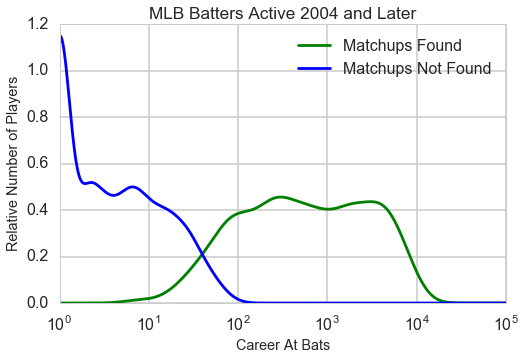

In [15]:
#kde_ABs = stats.gaussian_kde(np.log10(ABs+1)) #make a KDE of density of log AB (+1 because many players with zero AB)
kde_missed = stats.gaussian_kde(np.log10(AB_missed + 1))
kde_found = stats.gaussian_kde(np.log10(AB_found+1))

fig, axis = plt.subplots(figsize=(8,5))
x = np.linspace(0, 5, 1000)
#axis.plot(10**x, kde_found(x)+kde_missed(x), 'k-', label='All \"Modern\" Batters')
axis.plot(10**x, kde_found(x), 'g-', label='Matchups Found')
axis.plot(10**x, kde_missed(x), 'b-', label='Matchups Not Found')
axis.set_xscale('log')
axis.set_xlabel('Career At Bats', fontsize='x-large'), axis.set_ylabel('Relative Number of Players', fontsize='x-large')
axis.set_title('MLB Batters Active 2004 and Later', fontsize='xx-large')
axis.legend(loc=0)

Ok. While there is a large population of players with missing matchup data, our sample is essentially 100% complete for batters who had at least 100 At Bats, who are the batters with enough statistics for us to concern ourselves with, anyways.

###Parse the Retrosheet HTML pages into a Matchup Dataframe

The pipeline below will take the dictionary of HTML text from each webpage, and convert it into a list of matchup statistics. Each element of the list is a dictionary holding the statistics for one batter-pitcher matchup.

In [16]:
def stats_parse(line):
    """
    Takes a line, which is a length-15 list of statistics for each matchup:
    R/L, AB, H, 2B, 3B, HR, BB, IBB, SO, HBP, SH, SF, AVG, OBP, SLG
    
    Returns a list with quantities: [AB, PA, H, TB, W, SO, SAC, RL]
    AB: At Bats
    PA: Plate Appearances (AB + W)
    H: Hits
    TB: Total Bases (H + 2*2B + 3*3B + 4*HR)
    W: Walks (BB + IBB + HBP)
    SO: Strike Outs
    SAC: Sacrifices (SH + SF)
    RL: Righty/Lefty pitcher
    """
    RL = line[0] #R/L handed pitcher
    AB = int(line[1]) #At Bats
    H = int(line[2]) #Hits
    TB = int(line[2]) + 2*int(line[3]) + 3*int(line[4]) + 4*int(line[5]) #Total Bases
    W = int(line[6]) + int(line[7]) + int(line[9]) #Walks (BB + IBB + HBP)
    PA = AB + W #Plate Appearances
    SO = int(line[8]) #Strikeouts 
    SAC = int(line[10]) + int(line[11]) #Sacrifices
    return [AB, PA, H, TB, W, SO, SAC, RL]

def parse_pages(pages, batterIDs=None):
    """
    Takes a dictionary pages with retroIDs of batters as keys,
    and the text of that batter's Retrosheet matchup sheet as values.
    Takes an optional array of retroIDs for batters.
    
    Returns a list of one dictionary for each batter-pitcher matchup, with fields:
    pID: pitcher ID
    bID: batter ID
    matchID: matchup ID, formatted as bID_pID
    AB: number of At Bats
    PA: number of Plate Appearances
    H: number of Hits
    SLUG: slugging value (H + 2*2B + 3*3B + 4*HR)
    W: number of Walks
    SO: number of Strike Outs
    SAC: number of Sac Flies and Sac Bunts
    """
    matchup_list = []
    
    if batterIDs is None:
        batterIDs = pages.keys()
    
    for batterID in batterIDs:
        text = pages[batterID]
        if text=='':
            continue
        soup = BeautifulSoup(pages[batterID], 'html.parser')
        data = soup.find_all('pre')[2]
        for i in np.arange(1, len(data.contents), 2):
            pitcherID = data.contents[i].get('href').split('/')[-1].split('.')[0].lstrip('P') #8-char retroID
            assert(len(pitcherID)==8)
            stats = data.contents[i+1].split('\n')[0].split() #list of stats values
            assert(len(stats) == 15)
            stats = stats_parse(stats)
            fields = ['AB', 'PA', 'H', 'TB', 'W', 'SO', 'SAC', 'RL']
            matchup = dict(zip(fields, stats))
            matchup['pID'] = pitcherID
            matchup['bID'] = batterID
            matchup['matchID'] = '%s_%s'%(batterID, pitcherID)

            matchup_list.append(matchup)
    return matchup_list

In [20]:
# %%time
# matchup_list = parse_pages(batter_pages)

Store and reload the results for later use.

In [ ]:
# f = open('data/matchups_2004.json', 'w')
# json.dump(matchup_list, f)
# f.close()

This step processes the list of matchups into a Pandas Dataframe.

In [21]:
matchup_df = pd.read_json("data/matchups_2004.json")

How many total matchups found?

In [22]:
len(matchup_df)

248420

##Calculate more matchup-specific and player-total statistics

In [27]:
#Matchup-specific totals
matchup_df['AVG'] = matchup_df['H']/matchup_df['AB']
matchup_df['OBP'] = (matchup_df['H'] + matchup_df['W'])/matchup_df['PA']
matchup_df.head(2)

,AB,H,PA,RL,SAC,SO,TB,W,bID,matchID,pID,AVG,OBP
0,5,1,5,R,0,2,1,0,torrc001,torrc001_medlk001,medlk001,0.2,0.2
1,3,0,3,L,1,2,0,0,kinnm002,kinnm002_leita001,leita001,0.0,0.0


Overall averages are totalled by batter ("ov\_") and by pitcher ("ovp\_")

In [28]:
batter_sums = matchup_df.groupby('bID').sum() #by-batter totals for H, AB, etc.
batter_matchups = matchup_df.groupby('bID')['AB'].count() #Number of pitchers seen by each player
batter_sums['FACED'] = batter_matchups
#Gives the overall average and OBP of batters
batter_sums['AVG'] = batter_sums['H']/batter_sums['AB']
batter_sums['OBP'] = (batter_sums['H'] + batter_sums['W'])/batter_sums['PA']
batter_sums['SO_PCT'] = batter_sums['SO']/batter_sums['PA']
batter_sums['W_PCT'] = batter_sums['W']/batter_sums['PA']
batter_sums['H_PCT'] = batter_sums['H']/batter_sums['PA']

batter_df = pd.DataFrame(batter_sums).reset_index()
rename = dict(zip(batter_df.columns, 'ov_'+batter_df.columns))
rename['bID'] = 'bID'
batter_df.rename(columns=rename, inplace=True)

batter_df.head(2)

,bID,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT
0,abada001,7,1,8,0,1,1,1,0.142857,0.25,2,0.125,0.125,0.125
1,abbop001,4,0,4,0,1,0,0,0.000000,0.00,1,0.250,0.000,0.000


In [30]:
pitcher_sums=matchup_df.groupby('pID').sum()
pitcher_matchups = matchup_df.groupby('pID')['AB'].count()
pitcher_sums['FACED'] = pitcher_matchups
#Gives the overall strike out, walk and hit percentage of pitchers
pitcher_sums['SO_PCT'] = pitcher_sums['SO']/pitcher_sums['PA']
pitcher_sums['W_PCT'] = pitcher_sums['W']/pitcher_sums['PA']
pitcher_sums['H_PCT'] = pitcher_sums['H']/pitcher_sums['PA']
pitcher_sums['AVG'] = pitcher_sums['H']/pitcher_sums['AB']
pitcher_sums['OBP'] = pitcher_sums['W_PCT']+pitcher_sums['H_PCT']

pitcher_df = pd.DataFrame(pitcher_sums).reset_index()
rename = dict(zip(pitcher_df.columns, 'ovp_'+pitcher_df.columns))
rename['pID'] = 'pID'
pitcher_df.rename(columns=rename, inplace=True)

pitcher_df.head(2)

,pID,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,aardd001,564,131,662,11,142,261,98,0.232270,0.345921,119,0.214502,0.148036,0.197885
1,aased001,27,6,33,1,5,10,6,0.222222,0.363636,6,0.151515,0.181818,0.181818


The new matchup Dataframe is as follows. Each matchup is represented by one row, and each row has both the matchup-specific stats (like "AB", "H", etc.) as well as the overall totals for the batter ("ov_AB", "ov_SO", etc.) and for the pitcher ("ovp_AB", 'ovp_SO", etc.).

Note that these "totals" are calculated as the totals for all listed matchups (PA >~ 4), so these total stats will be slightly different than the career totals from the Lahman Database 

In [26]:
bigdf = matchup_df.copy()
for df in [batter_df, pitcher_df]:
    bigdf = bigdf.merge(df, how='left')
    
bigdf.head()

,AB,H,PA,RL,SAC,SO,TB,W,bID,matchID,pID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,5,1,5,R,0,2,1,0,torrc001,torrc001_medlk001,medlk001,0.200000,0.200000,5,1,5,0,2,1,0,0.200000,0.200000,1,0.400000,0.00000,0.200000,1405,357,1502,13,297,674,97,0.254093,0.302264,188,0.197736,0.064581,0.237683
1,3,0,3,L,1,2,0,0,kinnm002,kinnm002_leita001,leita001,0.000000,0.000000,3,0,3,1,2,0,0,0.000000,0.000000,1,0.666667,0.00000,0.000000,5014,1260,5776,91,1023,2335,762,0.251296,0.350069,356,0.177112,0.131925,0.218144
2,6,0,6,R,0,0,0,0,telit001,telit001_felds001,felds001,0.000000,0.000000,12,2,12,0,2,4,0,0.166667,0.166667,2,0.166667,0.00000,0.166667,3602,979,3985,53,556,1835,383,0.271793,0.341782,347,0.139523,0.096110,0.245671
3,6,2,6,R,0,2,4,0,telit001,telit001_grays001,grays001,0.333333,0.333333,12,2,12,0,2,4,0,0.166667,0.166667,2,0.166667,0.00000,0.166667,793,177,864,9,189,289,71,0.223203,0.287037,110,0.218750,0.082176,0.204861
4,3,0,4,R,2,3,0,1,schic002,schic002_adamt001,adamt001,0.000000,0.250000,411,66,424,62,143,84,13,0.160584,0.186321,72,0.337264,0.03066,0.155660,2076,566,2346,34,399,937,270,0.272640,0.356351,243,0.170077,0.115090,0.241262


In [31]:
bigdf.to_csv("data/big.csv", index=False)

#2. Exploratory Data Analysis

In [32]:
get_one = np.random.choice

In [33]:
#Reload the dataframe from this point, if desiring to start from this point.
big_df = pd.read_csv("data/big.csv")

Distribution of matchup averages (one pitcher against one batter)

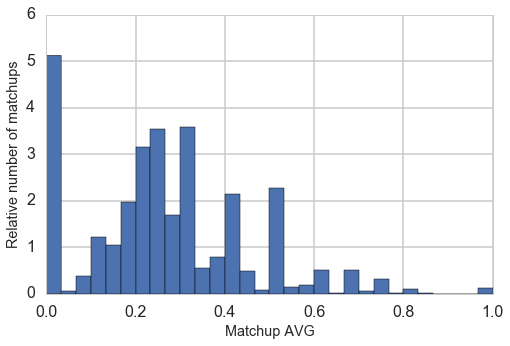

In [34]:
AVG = big_df.AVG.values
AVG[np.isnan(AVG)] =0.
fig, axis = plt.subplots(figsize=(8,5))
axis.hist(big_df.AVG, bins=30, normed=True)
axis.set_xlabel('Matchup AVG', fontsize='x-large')
axis.set_ylabel('Relative number of matchups', fontsize='x-large')
plt.savefig('/Users/bcook/Desktop/matchup_avg.jpg')

In [35]:
print("Overall details of our dataframe:")
print('Total matchups: %d'%(len(bigdf)))
print('Unique batters: %d'%(len(batter_df)))
print('Unique pitchers: %d'%(len(pitcher_df)))
print('Coverage fraction: %.3f (Number of all possible matchups which were encountered)'%(float(len(bigdf)) / (len(batter_df)*len(pitcher_df))))

Overall details of our dataframe:
Total matchups: 248420
Unique batters: 1864
Unique pitchers: 2684
Coverage fraction: 0.050 (Number of all possible matchups which were encountered)


How many times has each batter/pitcher seen each other? (PAs)

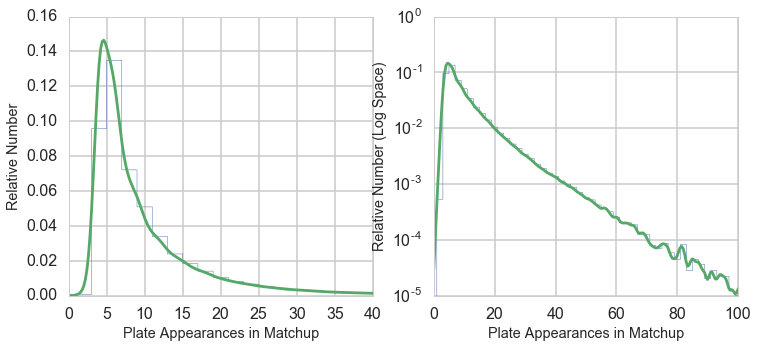

In [36]:
kde_times_seen = stats.gaussian_kde(bigdf['PA'])

fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
axis=axes[0]
axis.hist(bigdf['PA'], normed=True, bins=80, histtype='step')
x = np.linspace(0, 40, 200)
axis.plot(x, kde_times_seen(x))
axis.set_xlim([0, 40])
axis.set_xlabel('Plate Appearances in Matchup', fontsize='x-large')
axis.set_ylabel('Relative Number', fontsize='x-large')

axis=axes[1]
axis.hist(bigdf['PA'], normed=True, bins=80, histtype='step')
x = np.linspace(0, 100, 200)
axis.plot(x, kde_times_seen(x))
axis.set_xlim([0, 100])
axis.set_yscale('log')
axis.set_xlabel('Plate Appearances in Matchup', fontsize='x-large')
axis.set_ylabel('Relative Number (Log Space)', fontsize='x-large')

How many pitchers/batters have each player faced?

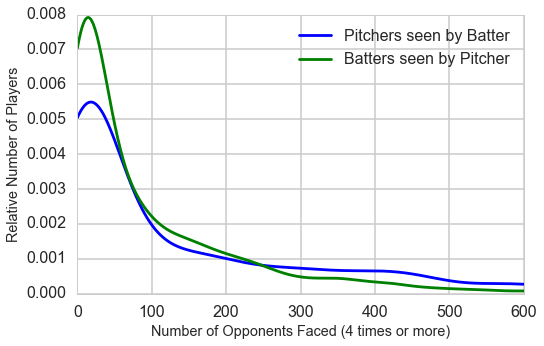

In [37]:
kde_b_matchups = stats.gaussian_kde(bigdf.groupby('bID').ov_FACED.agg(get_one))
kde_p_matchups = stats.gaussian_kde(bigdf.groupby('pID').ovp_FACED.agg(get_one))

fig, axis = plt.subplots(figsize=(8,5))
x = np.linspace(0, 600, 500)
plt.plot(x, kde_b_matchups(x), 'b-', label='Pitchers seen by Batter')
plt.plot(x, kde_p_matchups(x), 'g-', label='Batters seen by Pitcher')
axis.set_xlabel('Number of Opponents Faced (4 times or more)', fontsize='x-large')
axis.set_ylabel('Relative Number of Players', fontsize='x-large')
axis.legend(loc=0)

It seems that a large fraction of batters faced fewer than 100 pitchers, and vice-versa.

What does the distribution of AVG look like across all batters/pitchers?

Mean batter AVG: 0.220
Median batter AVG: 0.246
Mean batter OBP: 0.277
Median batter OBP: 0.307

Mean pitcher AVG: 0.280
Median pitcher AVG: 0.275
Mean pitcher OBP: 0.363
Median pitcher OBP: 0.356


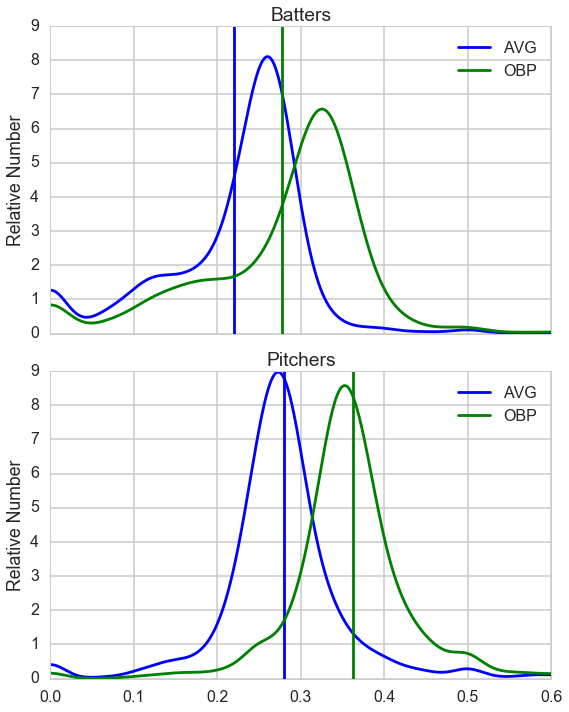

In [38]:
fig, axes = plt.subplots(figsize=(8, 10), nrows=2, sharex=True)
axis=axes[0]
AVG, OBP = bigdf.groupby('bID')['ov_AVG'].agg(get_one), bigdf.groupby('bID')['ov_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b-', label='AVG')
axis.axvline(AVG.mean(), color='b', ls='-')
print('Mean batter AVG: %.3f'%(AVG.mean()))
print('Median batter AVG: %.3f'%(AVG.median()))

axis.plot(x, kde_O(x), 'g-', label='OBP')
axis.axvline(OBP.mean(), color='g', ls='-')
print('Mean batter OBP: %.3f'%(OBP.mean()))
print('Median batter OBP: %.3f\n'%(OBP.median()))
axis.set_title("Batters")
axis.set_ylabel('Relative Number')
axis.legend()

axis=axes[1]
AVG, OBP = bigdf.groupby('pID')['ovp_AVG'].agg(get_one), bigdf.groupby('pID')['ovp_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b-', label='AVG')
axis.axvline(AVG.mean(), color='b', ls='-')
print('Mean pitcher AVG: %.3f'%(AVG.mean()))
print('Median pitcher AVG: %.3f'%(AVG.median()))

axis.plot(x, kde_O(x), 'g-', label='OBP')
axis.axvline(OBP.mean(), color='g', ls='-')
print('Mean pitcher OBP: %.3f'%(OBP.mean()))
print('Median pitcher OBP: %.3f'%(OBP.median()))
axis.set_title("Pitchers")
axis.set_ylabel('Relative Number')
axis.legend()
plt.tight_layout()

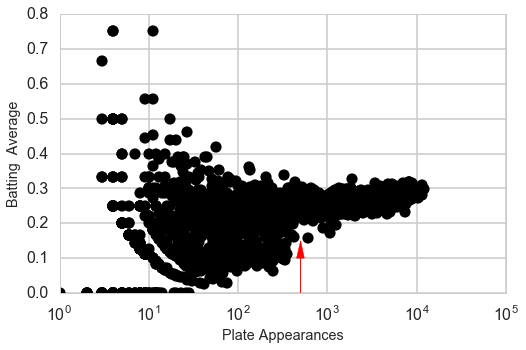

In [39]:
fig, axis = plt.subplots(figsize=(8,5))
axis.plot(big_df.groupby('bID')['ov_PA'].agg(get_one), big_df.groupby('bID')['ov_AVG'].agg(get_one), 'ko')
axis.set_xscale('log')
axis.arrow(500, 0.0, 0, 0.1, head_width=100., head_length=.05, color='r')
axis.set_xlabel('Plate Appearances', fontsize='x-large')
axis.set_ylabel('Batting  Average', fontsize='x-large')

Although this does not have to do with our final analysis, we found an interesting result here. There is a sharp narrowing in the distribution of batting averages among players with >500 plate appearances. Either players suddenly get much better after that much time or (more realistically), players who have not shown they can hit well are cut from the Major Leagues.

#3. Shrinking the Dataset

##Remove matchups and players with low statistics

In [40]:
#Reload dataset from here, in case want to begin from this part of the code
bigdf = pd.read_csv("data/big.csv")
dftouse=bigdf.copy()
dftouse.head()

,AB,H,PA,RL,SAC,SO,TB,W,bID,matchID,pID,AVG,OBP,ov_AB,ov_H,ov_PA,ov_SAC,ov_SO,ov_TB,ov_W,ov_AVG,ov_OBP,ov_FACED,ov_SO_PCT,ov_W_PCT,ov_H_PCT,ovp_AB,ovp_H,ovp_PA,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_AVG,ovp_OBP,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT
0,5,1,5,R,0,2,1,0,torrc001,torrc001_medlk001,medlk001,0.200000,0.200000,5,1,5,0,2,1,0,0.200000,0.200000,1,0.400000,0.00000,0.200000,1405,357,1502,13,297,674,97,0.254093,0.302264,188,0.197736,0.064581,0.237683
1,3,0,3,L,1,2,0,0,kinnm002,kinnm002_leita001,leita001,0.000000,0.000000,3,0,3,1,2,0,0,0.000000,0.000000,1,0.666667,0.00000,0.000000,5014,1260,5776,91,1023,2335,762,0.251296,0.350069,356,0.177112,0.131925,0.218144
2,6,0,6,R,0,0,0,0,telit001,telit001_felds001,felds001,0.000000,0.000000,12,2,12,0,2,4,0,0.166667,0.166667,2,0.166667,0.00000,0.166667,3602,979,3985,53,556,1835,383,0.271793,0.341782,347,0.139523,0.096110,0.245671
3,6,2,6,R,0,2,4,0,telit001,telit001_grays001,grays001,0.333333,0.333333,12,2,12,0,2,4,0,0.166667,0.166667,2,0.166667,0.00000,0.166667,793,177,864,9,189,289,71,0.223203,0.287037,110,0.218750,0.082176,0.204861
4,3,0,4,R,2,3,0,1,schic002,schic002_adamt001,adamt001,0.000000,0.250000,411,66,424,62,143,84,13,0.160584,0.186321,72,0.337264,0.03066,0.155660,2076,566,2346,34,399,937,270,0.272640,0.356351,243,0.170077,0.115090,0.241262


When we shrink the dataframe, or split it into training/validation/test sets, we want to be able to recompute the "totalled" statistics, like "ov_AVG" and "ovp_FACED", so that each smaller dataframe only knows the details of itself. This keeps the validation/test data from polluting the training set, and vice-versa.

In [41]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all totalled statistics recomputed.
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    nldf=ldf.copy()
    
    #Totalled pitcher stats
    nldf.set_index(['pID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ovp_'+col] = ldfp[col].sum()
    nldf['ovp_AVG'] = nldf['ovp_H']/nldf['ovp_AB']
    nldf['ovp_FACED']= ldfp.AB.count()
    nldf['ovp_OBP'] = (nldf['ovp_H'] + nldf['ovp_W'])/nldf['ovp_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ovp_' + col + '_PCT'] = nldf['ovp_' + col] / nldf['ovp_PA']
    nldf.reset_index(inplace=True)
    
    #Totalled batter stats
    nldf.set_index(['bID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ov_'+col] = ldfb[col].sum()
    nldf['ov_AVG'] = nldf['ov_H']/nldf['ov_AB']
    nldf['ov_FACED']= ldfb.AB.count()
    nldf['ov_OBP'] = (nldf['ov_H'] + nldf['ov_W'])/nldf['ov_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ov_' + col + '_PCT'] = nldf['ov_' + col] / nldf['ov_PA']
    nldf.reset_index(inplace=True)
    return nldf

In [42]:
def make_smaller(df, col, limit, greater=True):
    """
    Given a dataframe df, shrink the dataframe by removing all rows where the column "col" is
    above or below a given limit.
    """
    if greater:
        smallidf = df[(df[col] > limit)]
    else:
        smallidf = df[(df[col] < limit)]
    return recompute_frame(smallidf)

In [43]:
min_matchup_PA = 7
min_batter_PA = 100
min_pitcher_PA = 100

#Set minimum number of times batter/pitcher faced each other
smalldf = make_smaller(dftouse, 'PA', min_matchup_PA)

#Set minimum number of total plate appearances for batter and pitcher
smalldf = make_smaller(smalldf, 'ov_PA', min_batter_PA)
smalldf = make_smaller(smalldf, 'ovp_PA', min_pitcher_PA)

smalldf.to_csv('small.csv', index=False)

In [44]:
print("Effect of Shrinking:")
print('Value:\t\t\tBefore\t\tAfter')
print('Number of matchups:\t%d\t\t%d'%(len(big_df), len(smalldf)))
print('Unique batters:\t\t%d\t\t%d'%(len(bigdf.groupby('bID')), len(smalldf.groupby('bID'))))
print('Unique pitchers:\t%d\t\t%d'%(len(bigdf.groupby('pID')), len(smalldf.groupby('pID'))))
frac_1 = float(len(bigdf))/(len(bigdf.groupby('bID'))*len(bigdf.groupby('pID')))
frac_2 = float(len(smalldf))/(len(smalldf.groupby('bID'))*len(smalldf.groupby('pID')))
print('Coverage fraction:\t%.3f\t\t%.3f'%(frac_1, frac_2))

Effect of Shrinking:
Value:			Before		After
Number of matchups:	248420		109688
Unique batters:		1864		910
Unique pitchers:	2684		1297
Coverage fraction:	0.050		0.093


How did this change the statistics of players left?

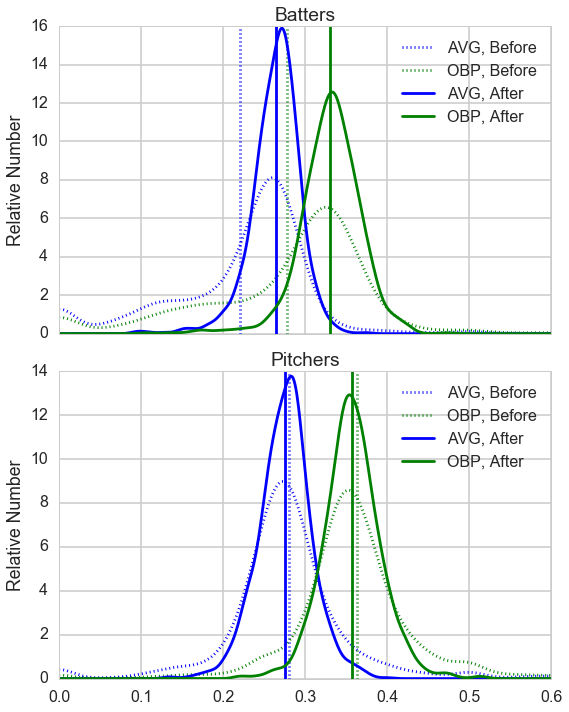

In [45]:
fig, axes = plt.subplots(figsize=(8, 10), nrows=2, sharex=True)
axis=axes[0]
AVG, OBP = bigdf.groupby('bID')['ov_AVG'].agg(get_one), bigdf.groupby('bID')['ov_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b:', label='AVG, Before')
axis.axvline(AVG.mean(), color='b', ls=':')

axis.plot(x, kde_O(x), 'g:', label='OBP, Before')
axis.axvline(OBP.mean(), color='g', ls=':')

AVG, OBP = smalldf.groupby('bID')['ov_AVG'].agg(get_one), smalldf.groupby('bID')['ov_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b-', label='AVG, After')
axis.axvline(AVG.mean(), color='b', ls='-')

axis.plot(x, kde_O(x), 'g-', label='OBP, After')
axis.axvline(OBP.mean(), color='g', ls='-')
axis.set_title("Batters")
axis.set_ylabel('Relative Number')
axis.legend()

axis=axes[1]
AVG, OBP = bigdf.groupby('pID')['ovp_AVG'].agg(get_one), bigdf.groupby('pID')['ovp_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b:', label='AVG, Before')
axis.axvline(AVG.mean(), color='b', ls=':')

axis.plot(x, kde_O(x), 'g:', label='OBP, Before')
axis.axvline(OBP.mean(), color='g', ls=':')

AVG, OBP = smalldf.groupby('pID')['ovp_AVG'].agg(get_one), smalldf.groupby('pID')['ovp_OBP'].agg(get_one)
kde_A = stats.gaussian_kde(AVG)
kde_O = stats.gaussian_kde(OBP)
x = np.linspace(0, .6, 1000)
axis.plot(x, kde_A(x), 'b-', label='AVG, After')
axis.axvline(AVG.mean(), color='b', ls='-')

axis.plot(x, kde_O(x), 'g-', label='OBP, After')
axis.axvline(OBP.mean(), color='g', ls='-')
axis.set_title("Pitchers")
axis.set_ylabel('Relative Number')
axis.legend()
plt.tight_layout()

By removing matchups where batter/pitchup faced eachother only a few times, and by removing batters/pitchers who had few total plate appearances, we have improved the total covering fraction of our data, and have removed the low-AVG tail among batter AVGs.

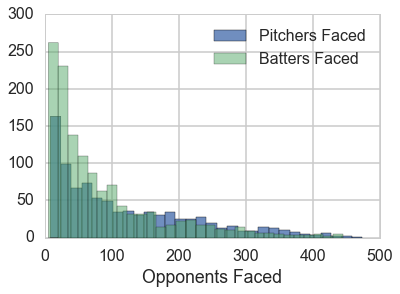

In [46]:
plt.hist(smalldf.groupby('bID').ov_FACED.agg(get_one), bins=30, alpha=0.8, label='Pitchers Faced')
plt.hist(smalldf.groupby('pID').ovp_FACED.agg(get_one), bins=30, alpha=0.5, label='Batters Faced')
plt.xlabel('Opponents Faced')
plt.legend();
plt.show()

##Split into Training/Test sets

We make sure that each batter has matchups in the training set. For most batters, we take 10 random matchups and put them in the test set, placing the rest in the training set. For batters with relatively few matchups, we leave at least 2/3 their total matchups in the training set.

In [62]:
trainlist=[]
testlist=[]
take=10 #At most 10 matchups in test set
for k, v in smalldf.groupby('bID'):
    train_rows, test_rows = train_test_split(v, test_size=min(take, len(v)/3))
    trainlist.append(train_rows)
    testlist.append(test_rows) 
traindf=pd.concat(trainlist)
testdf=pd.concat(testlist)

In [48]:
print('Size of datasets:\nTraining:\t%d\nTest:\t\t  %d'%(len(traindf), len(testdf)))

Size of datasets:
Training:	101481
Test:		  8207


Make sure that each pitcher was encountered in the training set. The number should be zero

In [63]:
masktest = np.in1d(testdf.pID, traindf.pID)
print 'Should be zero: ',np.sum(~masktest)

Should be zero:  0


In [64]:
traindf.to_csv("data/training.csv", index=False)
testdf.to_csv("data/test.csv", index=False)

#4. Baseline Model

Reload train/validate/test sets from disk, in case want to start from this point in the code

In [23]:
traindf = pd.read_csv("data/training.csv")
testdf = pd.read_csv("data/test.csv")

In order to predict the batting average a batter will see against a new pitcher, we first develop a baseline model, which works as follows.

First, we compute the *global batting average* $\bar{Y}$ for all matchups in our training set. Then, we calculate the *bias* of each batter and pitcher. A batter's bias is how much his overall AVG deviates from the global AVG, and the pitcher's is the same. A good batter would have a positive bias, and a good pitcher would have a negative bias. Then, for a new matchup, our baseline model predicts that the matchup average is the global average plus the pitcher and batters biases:

For a matchup between batter $b$ (with overall AVG $\bar{Y_b}$) and pitcher $p$ (with overall AVG $\bar{Y_p}$), our predicted matchup average $\hat{Y}_{b,p}$ is:
$$\begin{align*}
\hat{Y}_{b,p} &= global\,AVG + batter\,bias + pitcher\,bias\\
&=\bar{Y} + (\bar{Y_b} - \bar{Y}) + (\bar{Y_p} - \bar{Y})\end{align*}$$

In [24]:
#Compute the global AVG
ybar = traindf.H.sum() / float(traindf.AB.sum())
print('Global AVG in Training Set: %.4f'%ybar)

Global AVG in Training Set: 0.2742


In [25]:
ubids=traindf.bID.unique()#unique-pitcher-ids
upids=traindf.pID.unique()#unique-batter-ids
print('%d pitchers, %d batters'%(len(upids),len(ubids)))

1298 pitchers, 911 batters


In [77]:
ubidmap={v:k for k,v in enumerate(ubids)}#of length U
upidmap={v:k for k,v in enumerate(upids)}#of length M

In [78]:
#Compute the per-batter and per-pitcher biases in the training set
batter_biases={}
pitcher_biases={}

for uindx, batter in enumerate(ubids):
    batter_row=traindf[traindf.bID==batter]
    yb=batter_row.ov_AVG.unique()[0]
    bbaseline = yb - ybar
    batter_biases[batter]=bbaseline

for iindx, pit in enumerate(upids):
    pit_row=traindf[traindf.pID==pit]
    yp=pit_row.ovp_AVG.unique()[0]
    pbaseline = yp - ybar
    pitcher_biases[pit]=pbaseline

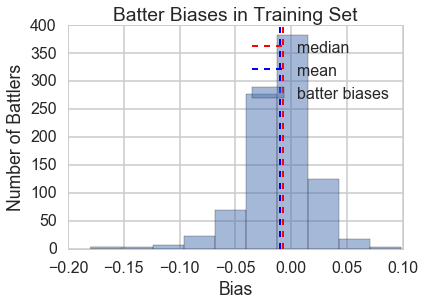

In [79]:
plt.hist(batter_biases.values(), alpha=0.5, label="batter biases");
plt.xlabel('Bias')
plt.ylabel('Number of Battlers')
plt.title('Batter Biases in Training Set')
plt.axvline(np.median(batter_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(np.mean(batter_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

We will not use it much, but the "universal" model simply predicts that all matchups will have the global batting average for all batters ($\bar{Y}$).

In [80]:
predictions={'universal':ybar+np.zeros(len(testdf))}

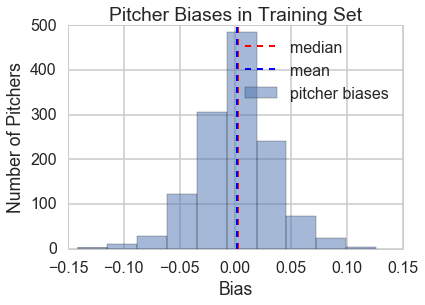

In [81]:
plt.hist(pitcher_biases.values(), alpha=0.5, label="pitcher biases");
plt.xlabel('Bias')
plt.ylabel('Number of Pitchers')
plt.title('Pitcher Biases in Training Set')
plt.axvline(x=np.median(pitcher_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(x=np.mean(pitcher_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

In [82]:
train_avgs={'mean':ybar, 'batters':batter_biases, 'pitchers':pitcher_biases}
pickle.dump(train_avgs, open('data/train_avgs.p', 'wb'))

In [83]:
train_avgs = pickle.load(open('data/train_avgs.p','rb'))

Compute the baseline model predictions for the test set, using the mean and biases computed in the training set.

In [84]:
#initializing list
list_pred=[]

#for each row in test df:
for row in range(len(testdf)):
    batterid_test=testdf.iloc[row]['bID'] #get the batter
    pitcherid_test=testdf.iloc[row]['pID'] #get the restuarant id
    list_pred.append(ybar+batter_biases[batterid_test]+pitcher_biases[pitcherid_test]) #call biases and calc. pred.
    predictions["baseline"]=list_pred #add to dictionary

# #initializing list
# list_pred2=[]
# #for each row in validate df:
# for row in range(len(validatedf)):
#     batterid_val=validatedf.iloc[row]['bID'] #get the batter
#     pitcherid_val=validatedf.iloc[row]['pID'] #get the restuarant id
#     list_pred2.append(ybar+batter_biases[batterid_val]+pitcher_biases[pitcherid_val])#call biases and calc. pred.
#     predictions_valid["baseline"]=list_pred2 #add to dictionary
# print len(predictions_valid['baseline'])

In [85]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.sum(diff**2)/len(diff))

In [86]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual averages and a numpy array of predicted averages
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=np.round(avg_actual, decimals=2), predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual AVG")
        ax.set_ylabel("predicted AVG")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    pearson = pearsonr(avg_actual, avg_predicted)[0]
    print "RMSE for %s: %.3f" %(model, rmse)
    print "Pearson r for %s: %.3f"%( model, pearson)
    rmse=3
    return ax,rmse

RMSE for baseline: 0.134
Pearson r for baseline: 0.258


(0.0, 0.8)

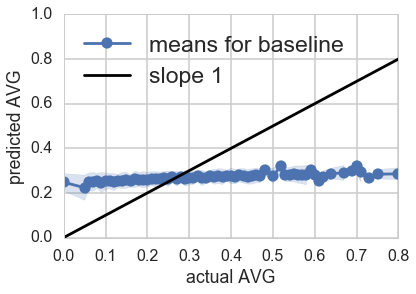

In [87]:
compare_results(testdf.AVG,predictions['baseline'], model="baseline");
plt.xlim([0.0, 0.8])

Our Baseline model is not that good, with there only being a slight difference between the predictions made for the matchups with the lowest and highest actual AVG. Let's see how we could improve on this model!

These are our numbers to beat:

RMSE of 0.135

Pearson r of 0.24

#5. Collaborative Filtering with KNN

In [88]:
smalldf = pd.read_csv('data/small.csv')
traindf = pd.read_csv('data/training.csv')
testdf = pd.read_csv('data/test.csv')
train_avgs = pickle.load(open('data/train_avgs.p','rb'))

This portion will require validation, not cross-validation, so we split the training set off here

In [89]:
traindf, validatedf = train_test_split(traindf, test_size=0.05)

In [90]:
masktest = np.in1d(validatedf.pID, traindf.pID)
print 'Should be zero:',np.sum(~masktest)

Should be zero: 0


In [91]:
ubids=traindf.bID.unique()#unique-pitcher-ids
upids=traindf.pID.unique()#unique-batter-ids
print('%d pitchers, %d batters'%(len(upids),len(ubids)))
ubidmap={v:k for k,v in enumerate(ubids)}#of length U
upidmap={v:k for k,v in enumerate(upids)}#of length M

1297 pitchers, 910 batters


Now that we have generated a baseline, we want to see if we can create a better model using *"K" Nearest Neighbor Collaborative Filtering* (KNN) to predict the batting average that a batter will achieve against a given pitcher.  Using Collaborative Filtering, we should be able to use the responses of *similar* batters regarding similar pitchers to get a better prediction. 

We can make an estimate of $Y_{um}$ as:

$$ \hat{Y_{um}} = \hat Y_{um}^{baseline}\, + \,\frac{\sum\limits_{j \in S^{k}(m)} s_{mj} ( Y_{uj} - \hat Y_{uj}^{baseline} )}{\sum\limits_{j \in S^{k}(m)} s_{mj} } $$
where $S^k(m)$ is the $k$ neighbor items of pitcher $m$ based on some *pooling criterion*, for example, those pitchers which have faced batter $u$.


To do this, we compute a similarity measure $s_{mj}$ between the $m$th and $j$th pitchers. Here we shall use the Pearson correlation coefficient. This measures the tendency of batters to get similar averages against the same pitcher. Since most the majority of batter-pitcher matchups have not actually faced each other in a Major League game, it is computed on the "common pitcher support" (`n_common`), which is the set of common pitchers a batter has faced. 

####Global Recommender

**$S^{k}(m)$ depends on pitchers only.**

Now we have a way to pool information between similar pitchers to try to predict a batter's average. But how do we choose the neighborhood to pool over? The simplest choice is to calculate the similarity between pitchers using their entire common batter support, and rank the nearest neighbors of a pitcher by this similarity. We call this a "global" recommender because it assumes that every batter perceives the similarity between pitchers in the same way. 
The global recommender does have the advantage of dealing with the possible sparsity of the batter's total number of at-bats, but also the disadvantage of giving one answer for all batters, without taking the batter's athletic talents, skills or experience into account. This is essentially bias-variance tradeoff.

####Local Recommender

**$S^{k}(p) = S^{k}(p;b)$ depends on pitchers and the batter in question **

Here we want more fine-grained predictions about each batter, and try to predict what batting average a batter would have against a pitcher they have never faced before. To do this, we will try to "personalize" the data we use even further, and only pool information from pitchers that the batter has faced.

We then go back to our issue of predicting $Y_{bp}$ for a pitcher $p$ that batter $b$ has never faced before. Using our similarity metrics that we calculated, we can modify our original baseline estimate by pulling in information from the batter's "neighborhood" of the pitcher $p$, and predict $Y_{bp}$ as:

$$ \hat{Y_{bp}} = \hat Y^{baseline}_{bp}\, + \,\frac{\sum\limits_{j \in S^{k}(p;b)} s_{pj} ( Y_{bj} - \hat Y^{baseline}_{bj} )}{\sum\limits_{j \in S^{k}(p;b)} s_{pj} } $$

where $s^{k}(p;p)$ is the $k$ neighbor pitchers of pitcher $p$ hich have face batter $b$.

This is not a great assumption, especially when a pitcher is new or a batter is new, or in the case when there are very few at bats for a pitcher or batter.

When adding the similarity term, we subtract the baseline estimate from the observed batting average of the batter's neighboring pitchers.

###Common Support

For each pair of pitchers, it is the number of batters who faced both pitchers, and it is used to modify the similarity between pitchers. If the common support is low, the similarity is less believable, and we "regularize" it by some average estimate.

We generate a two dimensional array `supports` uses the `upidmap`, and a Pandas Series `bats` with index pitcher ids which we will use later. We obtain the common batters as an intersection between two batters who have faced the same pitcher. 

In [6]:
def compute_supports(df):
    bats = df.groupby('pID').bID.unique()
    batters = df.bID.unique()
    pitchers = df.pID.unique()
    lpitch=len(pitchers)
    bdict={}
    for e,v in zip(bats.index.values, bats.values):
        bdict[e] = np.array([item in v for item in batters])
    supports=[[[] for i in range(lpitch)] for i in range(lpitch)]
    supporthistlist=[]
    for i,p1 in enumerate(pitchers):
        for j,p2 in enumerate(pitchers):
            if  i <= j:#its symmetric
                if p1==p2:
                    common_pitchers=bats[p1]
                else:
                    common_pitchers = set(bats[p1]).intersection(set(bats[p2]))
                    supporthistlist.append(len(common_pitchers))
                supports[i][j]=common_pitchers
                supports[j][i]=common_pitchers
    return supports, bdict, supporthistlist

In [78]:
supports, bdict, s = compute_supports(traindf)
_, _, s_full = compute_supports(smalldf)

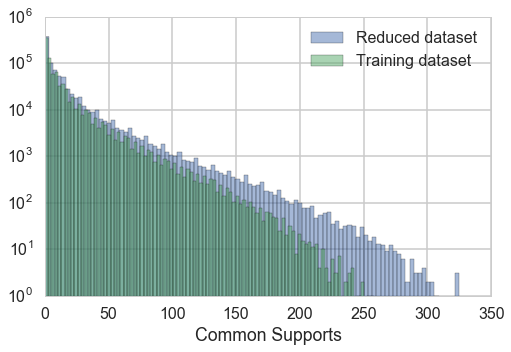

In [79]:
fig, axis = plt.subplots(figsize=(8,5))
axis.hist(s_full, bins=100, log=True, alpha=0.5, label='Reduced dataset')
axis.hist(s,bins=100, log=True, alpha=0.5, label='Training dataset')
axis.set_xlabel('Common Supports')
axis.legend(loc=0)

We see that the common support is a bit lower on the training set due to the loss of some batting averages to the validation and test sets.  

##Calculating similarity

We computed a baseline model to take into account that for some batters whose overall batting average is low, they could still have a bating average for a given pitcher that is relatively high.  Similarly, stronger overall batters may have a "fluke" low batting average against certain pitchers.

We call the model of similarity below the __Data-driven__ model, because we base our similarities simply on the data (namely, how pitchers matched up against different batters). This is a "Baseball-blind" model.

We will later compare this to our __Sabermetric__ model, which uses an algorithm developed by experienced Baseball experts to compare two pitchers based on their career totals.

####Writing Pearson Coefficient Function

We must subtract the batters' batting averages from the actual averages they achieve against each pitcher in finding the similarity of two pitchers. This normalization allows us to compare two batters easily. We do this in the function `pearson_sim` defined below.

If there is no common support (`n_common=0`), we have no basis for making a similarity estimate, and so we set the similarity to 0. In the case that the individual pitcher's batting average against has a variance of 0 , such as in the case where there is only one common batter (`n_common=1`), we convert the `NaN` that the scipy `pearsonr` returns to`0.`.

In [7]:
# calculate pearson sim between 2 pitchers
def pearson_sim(pitcher1, pitcher2, n_common):
    p1_avg = pitcher1['ov_AVG']
    p2_avg = pitcher2['ov_AVG']
    p1_actual = pitcher1['AVG']
    p2_actual = pitcher2['AVG']
    norm1 = []
    norm2 = []
    if (n_common == 0) or (n_common==1):
        return 0;
    for i in range(0,len(p1_avg)):
        norm1.append(p1_avg[i] - p1_actual[i])
        norm2.append(p2_avg[i] - p2_actual[i])
    rho = pearsonr(norm1,norm2)[0]
    if np.isnan(rho):
        return 0;
    return rho

####Now we can Find the Pitchers' Averages Against

The function `get_pitcher_avgs` defined below takes a pitcher `pID` and a set of pitchers, and returns the averages against that pitcher for the batters who have faced him. This function will be used in the similarity function below. The set of batters is all of the batters who have gone up against the pitcher for the global recommender, and later, a restricted set for the local recommender.

In [8]:
def get_pitcher_avgs(pID, df, set_of_batters):
    """
    given a pitcher id and a set of batters, return the sub-dataframe of their
    averages.
    """
    mask = (df.bID.isin(set_of_batters)) & (df.pID==pID)
    avgs = df[mask]
    avgs = avgs[avgs.bID.duplicated()==False]
    return avgs

### Making a database of similarities

We now move to calculating a global database of pairwise pitcher similarities.
We generated a Class to make a database of the pitcher similarities for each pair of pitchers. 

Here's how we filled in the database:

1. For every pitcher pair, we get the set of batters who have matched up against both pitchers and compute the intersection of the two sets.  We also calculate the number of common batters `n_common`.

2. We get the batting average against for each pitcher as made by these common matchups and get the matchup averages and batters' batting averages.
3. We calculate the similarity using `similarity_func`.

4. We return the similarity and `n_common` in a tuple `(sim, n_common)`. If the similarity is a `NaN`, set the similarity to 0.

In [9]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, pindexmap, supports):
        "the constructor, takes a map of pitcher id's to integers"
        database={}
        self.pindexmap=pindexmap
        self.supports=supports
        l_keys=len(self.pindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two business ids"
        sim=self.database_sim[self.pindexmap[b1]][self.pindexmap[b2]]
        nsup=self.database_sup[self.pindexmap[b1]][self.pindexmap[b2]]
        return (sim, nsup)

Lets create an instance of the `Database class`, using the `supports` and `upidmap` we calculated when making the histogram of common supports.

In [261]:
db_data=Database(upidmap, supports)

### Map reduce to populate database

We fill in the database using a map-reduce computation.

We display here, an outline of the implementation, so that the steps in the process can be followed:

```python
def map_reduce(tuples)
    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped22)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output
tuples=traindf.itertuples()
sims=map_reduce(tuples)
```

In [262]:
def mapper1(row):
    return row[1], (row[2], row[12], row[34]) #pID, bID, matchup AVG, batter overall AVG
def combiner(items):
    indict={}
    for key, value in items:
        if not indict.has_key(key):
            indict[key]=[]
        indict[key].append(value)
    return indict.items()
def reducer1(the_input):
    bID, values = the_input
    avgs=[]
    for pID,AVG,ov_AVG in values:
        avgs.append((pID,(AVG, ov_AVG)))
    return bID, avgs
from itertools import combinations_with_replacement
def mapper2(list_input):
    nlist = []
    comb = list(combinations_with_replacement(list_input[1], 2))
    for item in comb:
        if item[0][0] > item[1][0]:
            pitch_pair = item[1][0], item[0][0]
            batter_pair = item[1][1], item[0][1]
        else:
            pitch_pair = item[0][0], item[1][0]
            avg_pair = item[0][1], item[1][1]
        tup = (pitch_pair, avg_pair)
        nlist.append(tup)
    return nlist
def combiner_list(itemslist):
    indict={}
    for items in itemslist:
        for key, value in items:
            if not indict.has_key(key):
                indict[key]=[]
            indict[key].append(value)
    return indict.items()
def reducer2(item_dict):
    p1_id = item_dict[0][0]
    p2_id = item_dict[0][1]
    AVG_1 = [x[0][0] for x in item_dict[1]]
    AVG_2 = [x[1][0] for x in item_dict[1]]
    ov_AVG_1 = [x[0][1] for x in item_dict[1]]
    ov_AVG_2 = [x[1][1] for x in item_dict[1]]
    n_common = len(item_dict[1])
    p1_dict = {'ov_AVG': ov_AVG_1, 'AVG': AVG_1}
    p2_dict = {'ov_AVG': ov_AVG_2, 'AVG': AVG_2}
    rho = pearson_sim(p1_dict, p2_dict, n_common)
    return (p1_id, p2_id),(rho, n_common)

In [263]:
def map_reduce(tuples):
    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped2)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output

In [86]:
# %%time
# tuples=traindf.itertuples()
# sims=map_reduce(tuples)

Running this code takes quite a while, so we saved the results, and reload them here.

In [88]:
# pickle.dump(sims,open('data/sims.p','wb'))
# sims = pickle.load(open('data/sims.p','rb'))

We now populate our instance of the database class by passing the instance `db` to the function `populate_from_mr` below. It takes the output of the reducer, finds the integer indices corresponding to the pitcher id's, and populates the slots in the database.

In [89]:
def populate_from_mr(db, mapredlist):
    for tpair,vpair in mapredlist:
        i1=db.pindexmap[tpair[0]]
        i2=db.pindexmap[tpair[1]]
        db.database_sim[i1][i2]=vpair[0]
        db.database_sup[i1][i2]=vpair[1]
        db.database_sim[i2][i1]=vpair[0]
        db.database_sup[i2][i1]=vpair[1]

In [90]:
# populate_from_mr(db_data, sims)

In [10]:
# pickle.dump(db_data, open('data/db_data.p','wb'))
db_data = pickle.load(open('data/db_data.p', 'rb'))

Lets check it for a pair pitcher results. 

In [11]:
tpair=('buehm001', 'hudst001') # Mark Buehrle vs. Tim Hudson
print db_data.get(tpair[0],tpair[1])

(-0.0093069421585641084, 205)


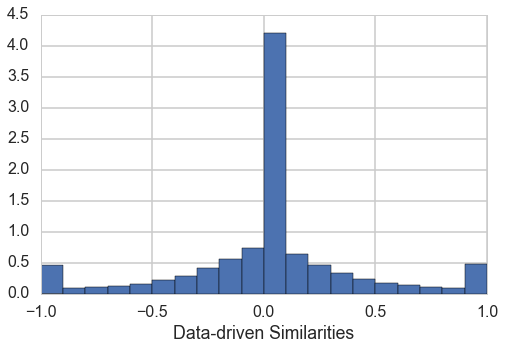

In [12]:
fig, axis = plt.subplots(figsize=(8,5))
flat_sims = db_data.database_sim.flatten()
axis.hist(flat_sims, bins=20, normed=True)
axis.set_xlabel('Data-driven Similarities')

#### Shrunk similarities

We now find the k-nearest neighbors of a given pitcher based on the database of similarities that we calculated. But we have a problem.

Consider the two cases where there are two common batters, and where there are 40. In the former case, we might get a artificially high similarity based on the averages of just a few batters, and thus we must reduce its importance in the nearest-neighbor calculation. The more batters there are for a given pitcher, the less bias we have in our model.

We can **shrink** our pearson co-efficients to decrease the effect of low supports. We shall do this by using the "regularization" parameter `reg`:

$$s_{mj} = \frac{N_{common}\, \rho_{mj}}{N_{common}+reg} $$

where $N_{common}$ (`n_common`) is the common batter support and $\rho_{ij}$ is the pearson co-relation coefficient.

We want to reduce the variance in our estimates, so we pull our estimates in toward a conservative point in a way that strongly corrals in estimates when there is very little data, but allows the data to speak when there is a lot. 

We define a function `shrunk_sim` which takes a `sim` and `n_common`, and shrinks the similarity down using the regularizer `reg`.

Note, we only apply this regularization for the __data-driven__ method, since our __Sabermetric__ method doesn't care about the number of common matchups.

In [31]:
def shrunk_sim(sim, n_common, reg=0.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

##An alternative method of calculating similarities

The following method for determining a quantitative similarity value for two pitchers was developed by the renowned baseball statistician Bill James: http://www.baseball-reference.com/about/similarity.shtml

The form of baseball analysis Bill James is credited with inventing is called Sabermetrics (named after the Society for American Baseball Research, SABR). So, we call this second similarity method the __Sabermetric__ method.

Start with a thousand and then subtract the following:

One point for each difference of 1 win.

One point for each difference of 2 losses.

One point for each difference of .002 in winning percentage (max 100 
points).

One point for each difference of .02 in ERA (max 100 points).

One point for each difference of 10 games pitched.

One point for each difference of 20 starts.

One point for each difference of 20 complete games.

One point for each difference of 50 innings pitched.

One point for each difference of 50 hits allowed.

One point for each difference of 30 strikeouts.

One point for each difference of 10 walks.

One point for each difference of 5 shutouts.

One point for each difference of 3 saves.

If they throw with a different hand and are starters subtract 10, relievers 25. For relievers you halve the winning percentage penalty. For all pitchers, the winning percentage penalty can be no larger than 1.5 times the wins and losses penalty. Relievers are defined as more relief appearances than starts and less than 4.00 innings per appearance.
We plugged all this in to create the lists you see on the player pages. Note that a player must have 100 innings pitched or 500 at bats before being considered, and to be truly accurate you need to look at whole careers, but it is fun to speculate all the same.

In [97]:
##input is a pitching_df rows corresponding to the 2 pitcher ids
def pitcher_sim(p1, p2):
    #Wins and Losses Penalties
    win_diff=np.abs(int(p1['W'])-int(p2['W'])) #1 pt for each win
    loss_diff=np.abs(int(p1['L'])-int(p2['L']))/2. #1 pt each 2 losses
    
    #Winning Percentage Penalty
    if int(p1['REL'])==1:     #winning percentage is halved for relief pitchers
        p1['WiP']=p1['WiP']/2.
    if int(p2['REL'])==1:
        p2['WiP']=p2['WiP']/2.
    wip_diff=np.abs(float(p1['WiP'])-float(p2['WiP']))/.002 #1 pt diff of winning percentage of 0.002 
    if wip_diff > 1.5*(win_diff+loss_diff): #winning percentage cannot be more than 1.5 times the penalties for win/loss differences 
        wip_diff= 1.5*(win_diff+loss_diff)
    if wip_diff >100: #penalty for winning percentage has a max= 100
        wip_diff=100   
    era_diff=np.abs(float(p1['ERA'])-float(p2['ERA']))/0.02 #1 pt diff of ERA of 0.02
    if era_diff >100:
        era_diff=100 #max =100
    
    #Handedness Penalties conditional on both pitchers being relief pitchers or not 
    if p1['RL'].values[0]!=p2['RL'].values[0] and int(p1['REL'])==0 and int(p2['REL'])==0: #handedness is different, relief pitchers
        hand_diff=10. 
    elif p1['RL'].values[0]!=p2['RL'].values[0] and int(p1['REL'])==1 and int(p2['REL'])==1.: #handedness is different, starters
        hand_diff=25.  
    else:
        hand_diff=0.
    
    #Additional Penalties
    gp_diff=np.abs(int(p1['G'])-int(p2['G']))/10. #1 pt for diff of 10 games played
    st_diff=np.abs(int(p1['GS'])-int(p2['GS']))/20. #1 pt for diff of 20 games started
    cg_diff=np.abs(int(p1['CG'])-int(p2['CG']))/20. #1 pt for diff of 20 games completed
    ip_diff=np.abs(float(p1['IP'])-float(p2['IP']))/50. #1 pt for diff of 50 innings pitched
    h_diff=np.abs(int(p1['H'])-int(p2['H']))/50. #1 pt for diff of 50 hits allowed
    so_diff=np.abs(int(p1['SO'])-int(p2['SO']))/30. #1 pt for diff of 30 strikeouts
    bb_diff=np.abs(int(p1['BB'])-int(p2['BB']))/50. #1 pt for diff of 10 walks
    sho_diff=np.abs(int(p1['SHO'])-int(p2['SHO']))/5. #1 pt for diff of 5 shutouts
    sv_diff=np.abs(int(p1['SV'])-int(p2['SV']))/3. #1 pt for diff of 3 saves

    score=1000 #generating starting score and subtracting penalties
    final_score=score-(win_diff+loss_diff+wip_diff+era_diff+gp_diff+st_diff+cg_diff+
                       ip_diff+h_diff+so_diff+bb_diff+sho_diff+sv_diff+hand_diff)
    #print final_score

    return final_score

In [98]:
#Loading in Relevant Dataframes
master = pd.read_csv('data/lahman/Master.csv')
pitching = pd.read_csv('data/lahman/Pitching.csv')
smalldf = pd.read_csv('data/small.csv')

In [99]:
#Convert the playerIDs between the Lahman database and the Retrosheet
retro_to_lah = dict(zip(master['retroID'], master['playerID']))
lah_to_retro = dict(zip(master['playerID'], master['retroID']))
retro_to_hand = dict(zip(master['retroID'], master['throws']))


In [100]:
def get_pitching_totals(pitching_df, upids):
    #Collect the required columns for a picthing Dataframe
    lah_pitchers = [retro_to_lah[name] for name in upids]
    pitching_totals = pitching.groupby('playerID').sum().reset_index()
    pitching_totals = pitching_totals[np.in1d(pitching_totals['playerID'], lah_pitchers)]
    pitching_totals.head()
    pitching_totals['BB_total'] = pitching_totals['BB'] + pitching_totals['IBB'] + pitching_totals['HBP']
    pitching_totals['pID'] = [lah_to_retro[name] for name in pitching_totals.playerID]
    pitching_totals['RL'] = [retro_to_hand[name] for name in pitching_totals.pID]
    pitching_totals['IP'] = pitching_totals['IPouts']/3.
    pitching_totals['Games']=pitching_totals['GS']-pitching_totals['G']/2. #if positive, more games started than games in relief
    pitching_totals['inningsper']=pitching_totals['IP']/pitching_totals['G'] #innings per game 
    relief=[1 if (i[1]['Games'] < 0. and i[1]['inningsper']<4.) else 0 for i in pitching_totals.iterrows()]
    pitching_totals['REL'] = relief
    pitching_totals['ERA'] = pitching_totals['ER'] *9. / (pitching_totals['IP'])
    pitching_totals['BAOpp'] = (pitching_totals.H + pitching_totals.BB_total) / pitching_totals.BFP #batting average against
    pitching_totals['WiP'] = pitching_totals.W/pitching_totals.G #win percentage

    return pitching_totals[['pID', 'W', 'L', 'ERA', 'RL', 'BAOpp', 'WiP', 'IP', 'REL', 'G', 'GS', 'CG', 'H', 'SO', 'BB', 'SHO', 'SV']]

In [101]:
pitching_totals = get_pitching_totals(pitching, upids)

In [102]:
db_saber = Database(upidmap, supports)

Rather than using MapReduce, here we simply populate the similarity matrix manually

In [107]:
def populate_by_calculating(db, df, similarity_func):
    """
    a populator for every pair of pitchers in df. takes similarity_func like
    pitcher_sim as argument
    """
    items=db.rindexmap.items()
    start = time.time()
    count = 0
    total = len(items)**2

    for p1, i1 in items:
        for p2, i2 in items:
            count += 1
            if (((100*count)/total) > ((100*(count-1))/total)):
                frac_done = (count+1)/float(total)
                time_elapsed = (time.time() - start) / (60.)
                remaining = ((1./frac_done)-1.)*time_elapsed
                print('%.1f percent done | elapsed: %.1f min | remaining: %.2f hour'%(frac_done *100, time_elapsed, remaining/60))
            if i1 <= i2:
                p1_row = df[df.pID==p1]
                p2_row = df[df.pID==p2]
                sim =similarity_func(p1_row, p2_row)
                db.database_sim[i1][i2]=sim
                db.database_sim[i2][i1]=sim

Running this code took a seriously long time (>7 hours), so we pickled the results.

In [13]:
# populate_by_calculating(db_saber, pitching_totals, pitcher_sim)
# pickle.dump(db_pitch,open('data/db_saber.p','wb'))
db_saber = pickle.load(open('data/db_saber.p', 'rb'))

In [14]:
tpair=('buehm001', 'hudst001') # Mark Buehrle vs. Tim Hudson
print db_saber.get(tpair[0],tpair[1])

(798.64799196070896, 205)


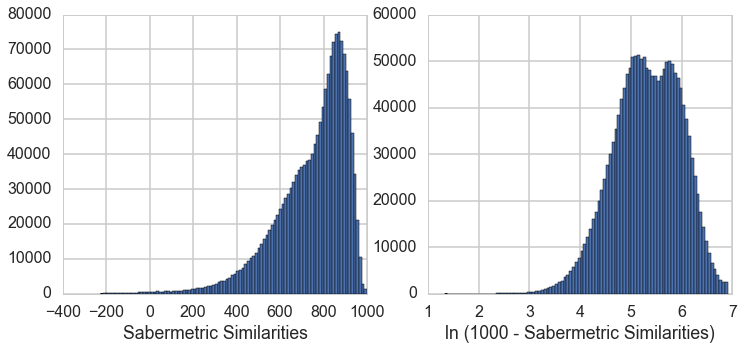

In [111]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2)
sims_pitch = db_saber.database_sim.flatten()

axis = axes[0]
axis.hist(sims_pitch, bins=100)
axis.set_xlabel('Sabermetric Similarities')
axis = axes[1]
sims_log = np.log(1000.01 - sims_pitch[(sims_pitch>0.) & (sims_pitch<1000.)])
axis.hist(sims_log, bins=100)
axis.set_xlabel('ln (1000 - Sabermetric Similarities)')

Interestingly, the similarity scores (once transformed to be based at zero) are roughly normal, with a slight bimodality. We suspect this bimodality is due to the relief pitcher - starting pitcher duality.

Let's compare the two measures of similarity

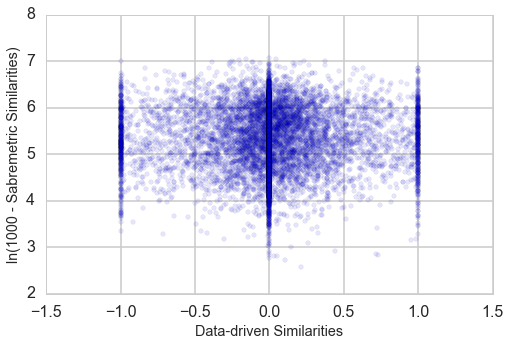

In [128]:
fig, axis = plt.subplots(figsize=(8,5))
x = db_data.database_sim.flatten()
y = np.log(1000-db_saber.database_sim.flatten())
mask = np.random.choice(range(len(x)), size=10000)
# axis.hexbin(x, y, gridsize=50, norm=mpl.colors.LogNorm())
axis.scatter(x[mask], y[mask], alpha=0.1)
axis.set_xlabel('Data-driven Similarities',fontsize='x-large')
axis.set_ylabel('ln(1000 - Sabremetric Similarities)', fontsize='x-large')

Interestingly, there does not seem to be much correlation between the data-driven similarities (which are highly peaked around -1, 0, and 1) and the Sabermetric similarities.

###Calculating Nearest Neighbors

Now we can move to writing a `knearest` function, which finds the `k` nearest neighbors of a given pitcher based on the shrunk similarities we calculate. The nearest neighbors are restricted to the pitchers a batter has faced.

We rescale to the 0-1 range to account for "negative" distances!

Data-driven:
$$ \rho \rightarrow \frac{1 - \rho}{2} $$.

Sabermetric:
$$ \rho \rightarrow \frac{1000 - \rho}{1000}$$

The distances are now always positive and between 0 and 1. 0 at full correlation, and 1 at full anticorrelation.

#### We write the `knearest` function

This function returns a *k-length sorted list* of 3-tuples each corresponding to a pitcher, the k-nearest pitchers to one we ask for.

The tuple structure is `(pID, shrunken distance, common support)` where the distance and common support are with respect to the pitchers whose neighbors we are finding, and the `pID` is the id of the "nearby" pitcher found. The nearby pitchers are found from a supplied numpy array of pitchers `set_of_pitchers`. We use `itemgetter` from the `operator` module to do the sorting. 

In [15]:
def dist_data(ssim):
    return (1.-ssim)/2.
def dist_saber(ssim):
    return (1000.-ssim)/1000.

In [16]:
from operator import itemgetter
def knearest(p_id, set_of_pitchers, dbase, dist_method, k=7, reg=0.):
    similars=[]
    for other_p_id in set_of_pitchers:
        if other_p_id!=p_id:
            sim, nc=dbase.get(p_id, other_p_id)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=dist_method(ssim)
            similars.append((other_p_id, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [17]:
def get_batters_pitchers(df, b_id):
    dfbatter=df[df.bID==b_id]
    dfbatterdedup=dfbatter.drop_duplicates('pID')
    return dict(zip(dfbatterdedup.pID.values, dfbatterdedup.AVG.values))

####Write a function to calculate the predicted batting average for a matchup

We write a function that returns the predicted  batting average for a matchup using the formula at the beginning of this problem. If the denominator of the function is 0, we use the baseline.  This function `get_avg` takes as arguments the `train_map` (for e.g., see `train_avg` from earlier which stores the baseline estimates of intercept (overall mean), batter bias, and pitcher bias), the database, the `set_of_pitchers`, the wanted `pID` and `bID`, and `k` as well as the regularizer `reg`.

In [18]:
def get_avg(set_of_pitchers, train_map, dbase, p_id, batter_id, dist_method, k=7, reg=0.):
    mu=train_map['mean']
    batter_bias = train_map['batters'][batter_id]
    nsum=0.
    scoresum=0.
    nears=knearest(p_id, set_of_pitchers, dbase, dist_method, k=k, reg=reg)
    pitcher_bias=train_map['pitchers'][p_id]
    scores=[]
    for p,s,nc in nears:
        ssim = 1-s
        scoresum=scoresum+ssim
        scores.append(ssim)
        p_biases = train_map['pitchers'][p]
        p_avgs = set_of_pitchers[p]
        dif=(p_avgs - (p_biases + batter_bias + mu))
        nsum=nsum+ssim*dif
    baseline=(batter_bias +pitcher_bias + mu)
    if scoresum > 0.:
        val =  nsum/scoresum + baseline
    else:
        val=baseline
    return val

####A prediction example

In [270]:
trainbatter=traindf.bID.unique()[210]
testpitcher=testdf[testdf.bID==trainbatter].pID.values[4]
print trainbatter, testpitcher
def get_actual(df, b_id, p_id):
    return df[(df.bID==b_id) & (df.pID==p_id)]['AVG'].values[0]

print "Actual", get_actual(testdf, trainbatter, testpitcher)
k, reg = 6, 8
print('With k=%d, reg=%.2f '%(k, reg))
print "Predicted: Data-driven",get_avg(get_batters_pitchers(traindf, trainbatter), train_avgs, db_data, testpitcher, trainbatter,dist_data, k=k, reg=reg)
print('With k=%d'%(k))
print "Predicted: Sabermetric",get_avg(get_batters_pitchers(traindf, trainbatter), train_avgs, db_saber, testpitcher, trainbatter, dist_saber, k=k, reg=0.)

burnj001 johnr005
Actual 0.181818181818
With k=6, reg=8.00 
Predicted: Data-driven 0.0958101555579
With k=6
Predicted: Sabermetric 0.169388163831


We now write a function to make a set of predictions on the validation set. This function takes an input dataframe `indf`, typically the validation or test set, and iterates over the averages in this frame, using the `get_avg` function we use to make predictions. It returns a tuple `preds, actuals`. Each of the variables represents an array of batting averages from `indf`, with `preds` being the predictions we made and `actuals` being the actual batting averages.

In [19]:
def get_avgs_batter_nbd(indf, traindf, train_map, db, dist_method, k=2, reg=0.):
    zips=zip(indf.pID, indf.bID, indf.AVG)
    preds=[]
    actuals=[]
    for (p,b,actual) in zips:
        pred=get_avg(get_batters_pitchers(traindf, b),train_map, db, p,b, dist_method, k, reg)
        preds.append(pred)
        actuals.append(actual)
    return np.array(preds), np.array(actuals)

To show the usage of this function, we set $k$ and `reg` to 4 and use it on the test set

RMSE for knn(data-driven) on test set, k=20, reg=4: 0.117
Pearson r for knn(data-driven) on test set, k=20, reg=4: 0.579
RMSE for knn(Sabermetric) on test set, k=20: 0.140
Pearson r for knn(Sabermetric) on test set, k=20: 0.143
CPU times: user 2min 24s, sys: 699 ms, total: 2min 24s
Wall time: 2min 26s


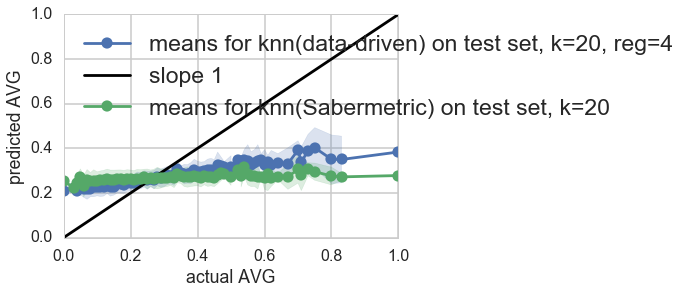

In [272]:
%%time
pt_data, at_data = get_avgs_batter_nbd(testdf, traindf, train_avgs, db_data, dist_data, k=20, reg=4.)
pt_saber, at_saber = get_avgs_batter_nbd(testdf, traindf, train_avgs, db_saber, dist_saber, k=20, reg=0.)
ax, _ = compare_results(at_data,pt_data, model="knn(data-driven) on test set, k=20, reg=4")
compare_results(at_saber,pt_saber, model="knn(Sabermetric) on test set, k=20", onsame=ax)

####Validate over k and reg

We loop through k and reg with several different sets to fine grain down our values.  

For the Data-driven KNN

In [110]:
%%time
k = range(12,32,1)
reg = range(1,10,1)
rmsedict_data = {}
pearsondict_data = {}
num = len(k)*len(reg)
i=0
start = time.time()
for kval in k:
    for regval in reg:
        i +=1
        elapsed = (time.time() - start) / (60.)
        print('Working on %d of %d. %.1f mins so far.'%(i, num, elapsed))
        pt, at = get_avgs_batter_nbd(validatedf, traindf, train_avgs, db_data, dist_data, k=kval, reg=regval)
        rmse = get_rmse(at, pt)
        pearson = pearsonr(at,pt)[0]         
        key = (kval, regval)
        rmsedict_data[key] = rmse
        pearsondict_data[key] = pearson

Working on 1 of 180. 0.0 mins so far.
Working on 2 of 180. 0.6 mins so far.
Working on 3 of 180. 1.2 mins so far.
Working on 4 of 180. 1.9 mins so far.
Working on 5 of 180. 2.5 mins so far.
Working on 6 of 180. 3.1 mins so far.
Working on 7 of 180. 3.7 mins so far.
Working on 8 of 180. 4.4 mins so far.
Working on 9 of 180. 5.0 mins so far.
Working on 10 of 180. 5.6 mins so far.
Working on 11 of 180. 6.2 mins so far.
Working on 12 of 180. 6.9 mins so far.
Working on 13 of 180. 7.5 mins so far.
Working on 14 of 180. 8.1 mins so far.
Working on 15 of 180. 8.7 mins so far.
Working on 16 of 180. 9.4 mins so far.
Working on 17 of 180. 10.0 mins so far.
Working on 18 of 180. 10.6 mins so far.
Working on 19 of 180. 11.2 mins so far.
Working on 20 of 180. 11.8 mins so far.
Working on 21 of 180. 12.5 mins so far.
Working on 22 of 180. 13.1 mins so far.
Working on 23 of 180. 13.7 mins so far.
Working on 24 of 180. 14.3 mins so far.
Working on 25 of 180. 15.0 mins so far.
Working on 26 of 180. 15.

For the Sabermetric KNN (We don't include regularization for the Sabermetric model, since we're not counting the number of matchups in common)

In [287]:
# %%time
# k = range(200, 300, 10)
# rmsedict_saber = {}
# pearsondict_saber = {}
# num = len(k)
# i=0
# start = time.time()
# for kval in k:
#     i +=1
#     elapsed = (time.time() - start) / (60.)
#     print('Working on %d of %d. %.1f mins so far.'%(i, num, elapsed))
#     pt, at = get_avgs_batter_nbd(validatedf, traindf, train_avgs, db_saber, dist_saber, k=kval, reg=0.)
#     rmse = get_rmse(at, pt)
#     pearson = pearsonr(at,pt)[0]         
#     key = kval
#     rmsedict_saber[key] = rmse
#     pearsondict_saber[key] = pearson

Working on 1 of 10. 0.0 mins so far.
Working on 2 of 10. 0.8 mins so far.
Working on 3 of 10. 1.6 mins so far.
Working on 4 of 10. 2.4 mins so far.
Working on 5 of 10. 3.1 mins so far.
Working on 6 of 10. 3.9 mins so far.
Working on 7 of 10. 4.7 mins so far.
Working on 8 of 10. 5.4 mins so far.
Working on 9 of 10. 6.1 mins so far.
Working on 10 of 10. 6.8 mins so far.
CPU times: user 7min 29s, sys: 2.06 s, total: 7min 31s
Wall time: 7min 33s


In [111]:
pickle.dump(pearsondict_data, open('data/pearsondict_data.p','wb'))
# pickle.dump(pearsondict_saber, open('data/pearsondict_saber.p','wb'))
pickle.dump(rmsedict_data, open('data/rmsedict_data.p','wb'))
# pickle.dump(rmsedict_saber, open('data/rmsedict_saber.p','wb'))

In [94]:
pearsondict_data = pickle.load(open('data/pearsondict_data.p','rb'))
pearsondict_saber = pickle.load(open('data/pearsondict_saber.p','rb'))
rmsedict_data = pickle.load(open('data/rmsedict_data.p','rb'))
rmsedict_saber = pickle.load(open('data/rmsedict_saber.p','rb'))

In [112]:
mintup_data=max(pearsondict_data, key=pearsondict_data.get)
mintup_saber = max(pearsondict_saber, key=pearsondict_saber.get)
print 'Data-driven:', mintup_data
print 'Sabermetrics:', mintup_saber

Data-driven: (15, 5)
Sabermetrics: 250


We now make predictions on the test set. Store these in `predictions['knn']`.

In [113]:
bestk_data, bestreg_data = mintup_data
bestk_saber = mintup_saber
predictions["knn_data"], atknn_data = get_avgs_batter_nbd(testdf, traindf,train_avgs, db_data, dist_data, k=bestk_data, reg=bestreg_data)
predictions['knn_saber'], atknn_saber = get_avgs_batter_nbd(testdf, traindf, train_avgs, db_saber, dist_saber, k=bestk_saber, reg=0.)

RMSE for knn(Data-driven) on test k=15, reg=5: 0.112
Pearson r for knn(Data-driven) on test k=15, reg=5: 0.619
RMSE for knn(Sabermetrics) on test k=250: 0.136
Pearson r for knn(Sabermetrics) on test k=250: 0.187


(<matplotlib.axes._subplots.AxesSubplot at 0x12715b110>, 3)

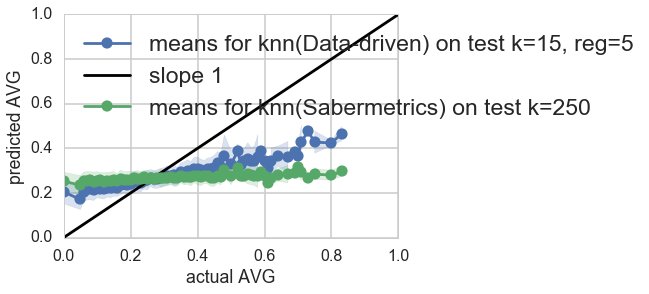

In [114]:
ax, rmse_knn = compare_results(testdf.AVG, predictions['knn_data'], model=("knn(Data-driven) on test k=" + str(bestk_data) + ", reg=" + str(bestreg_data)))
compare_results(testdf.AVG, predictions['knn_saber'], model=("knn(Sabermetrics) on test k=" + str(bestk_saber)), onsame=ax)

When comparing our kNN data-driven model and Sabermetrics model to our baseline, we see that neither model does a great job at predicting batting averages in any given matchup. The RMSE is still very high for both pitcher similarity methods, suggesting that the predictions we have made on the test set were not very close to the actual batting averages. Like with the baseline model, the batting averages that were very high were predicted to be a lot lower for both methods. 

However, we note that our data-driven method does have a slight improvement over the sabermetrics model, as the image above shows a slightly greater association between predicted batting average and actual batting average for the matchups. The batter-pitcher matchups that have a higher actual batting average are predicted to have a slightly higher batting average than the lower batting average using the data-driven model, suggesting that the data-driven model could potentially be useful in determining which batter might be a little bit better against a given pitcher. However, it is important to note that our predictions with the data driven model still have a fairly large error: even our data-driven model, while an improvement, has a .112 RMSE, which is pretty large in terms of batting average range. 

#6. Ridge Regression

Now we'll estimate the batting averages using regularized regressions.

First we look at the baseline model

$$ \hat Y_{bp}^{baseline} = \hat \mu + \hat \theta_{b} + \hat \gamma_{p} $$ 

and notice that \hat \mu can be interpreted as an intercept in a regression model. 

We can take the recommendation matrix $ \hat Y_{bp}^{baseline}$, which will have 0s for any batter-pitcher pair that have never faced off against each other, and flatten its non-zero elements into one vector. In simpler words, we can group together all of the data for any batter-pitchers pairs that we have data for into one vector column, and all of the data for batter-pitcher pairs that do not have any data in another vector column. 

Once we do that, we can also tweak the above baseline equation into a format that takes into account every unique batter and pitcher, in the form of indicator variables:

$$ Y_{bp}^{baseline} =  \mu + \bar \theta \cdot I_{b} +  \bar \gamma \cdot I_{p} $$

In the formula above, $I_{b}$ and $I_{p}$ are indicator variables for the bth batter and mth pitcher that go into our feature matrix we will use for our analysis. $I_{b}$ is a feature vector of all batters: it takes the value of 1 if the batter in question is batter $b$ and 0 if not. $I_{p}$ is the same feature vector for all pitchers. 

Because we have so many batter and pitcher coefficients to fit a model on, we can prevent overfitting by regularizing the regression. We adjust our model

$$  Y_{bp}^{baseline} =  \mu +  \bar \theta \cdot I_{b} +  \bar \gamma \cdot I_{p} $$

to minimize the sum of squared error

$$\sum_{b,p} \left( Y_{bp} -  \mu - \bar \theta \cdot I_{b} -  \bar \gamma \cdot I_{p} \right)^2 + \alpha \left( \theta_{b}^2 + \gamma_{p}^2 \right)$$

and form our ridge regression model!

In [65]:
traindf = pd.read_csv("data/training.csv")
testdf = pd.read_csv("data/test.csv")

We first begin by collecting the unique batters and unique pitchers from our training set

In [66]:
ubids=traindf.bID.unique()#unique-batter-ids
upids=traindf.pID.unique()#unique-pitcher-ids
from sklearn.linear_model import Ridge

Then we write a function `getmats` that takes in a dataframe (for example, our training set) and returns the batting average of each matchup in the dataframe in order as well as a design matrix. The design matrix, as explained above, has rows for each batter-pitcher matchup in the same order as the input dataframe, and a column for every unique batter and pitcher in the input dataframe. For each row corresponding to a batter-pitcher matchup, the column value is 1 if the batter-pitcher matchup is for that batter or pitcher, and 0 if not. Therefore, each row will have two 1's (one for each batter and pitcher in question) and a lot of zeros.

In [67]:
#function to produce the design matrix
def getmats(indf, ubids, upids):
    results_avg = indf['AVG']
    
    n_cols = len(ubids)+len(upids)
    n_rows = len(indf)
    
    #fill matrix with zeros
    mats = np.zeros((n_rows, n_cols))

    #for each element in features, check for match in every row, whether pitcher or batter, and switch to one
    for r in range(0, n_rows):
        a = np.in1d(ubids, indf.bID.values[r]).astype(int)
        b = np.in1d(upids, indf.pID.values[r]).astype(int)
        mats[r] = np.concatenate([a,b])
    return mats, results_avg

We then use `getmats` to create a design matrix for the training set and test set, as well as collect the corresponding actual batting averages for the batter-pitcher matchups in both sets. 

In [68]:
%%time
designm, avg = getmats(traindf, ubids, upids)
testm, test_avg = getmats(testdf, ubids, upids)

CPU times: user 10.6 s, sys: 807 ms, total: 11.4 s
Wall time: 11.9 s


We then fit the ridge regression model on the training set, and then use that regression instance to predict the batting averages for the batter-pitcher pairs in the test set. To determine the best values of $\alpha$, we use 5-fold cross validation to see which value gives us the lowest RMSE.

In [102]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [105]:
clf = Ridge()
alphas= np.arange(20, 60, 1)

In [106]:
%%time
gs = GridSearchCV(clf, param_grid=dict(alpha=alphas), cv=5)
gs.fit(designm, avg)
best = gs.best_estimator_

CPU times: user 1h 24min 25s, sys: 3min 40s, total: 1h 28min 5s
Wall time: 29min 50s


In [107]:
print(best)
pickle.dump(best, open('data/best_ridge.p', 'wb'))

Ridge(alpha=56, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)


In [38]:
best = pickle.load(open('data/best_ridge.p','rb'))

In [108]:
clf=best.fit(designm, avg)
training_accuracy = clf.score(designm, avg)
print "BEST: %s" % (clf.get_params())
print "############# based on standard predict ################"
print "Accuracy on training data: %0.5f" % (training_accuracy)
print "########################################################"

BEST: {'normalize': False, 'fit_intercept': True, 'solver': 'auto', 'max_iter': None, 'tol': 0.001, 'copy_X': True, 'alpha': 56}
############# based on standard predict ################
Accuracy on training data: 0.04751
########################################################


RMSE for ridge_reg, $\alpha$=56: 0.137
Pearson r for ridge_reg, $\alpha$=56: 0.154


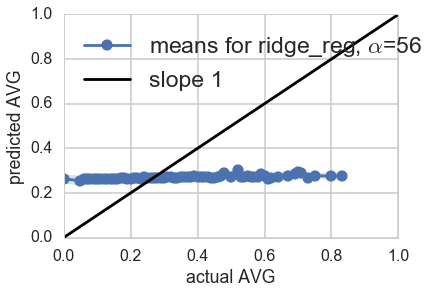

In [109]:
pred_test = best.predict(testm)
predictions['ridge_reg'] = pred_test

compare_results(test_avg,predictions['ridge_reg'], model=r"ridge_reg, $\alpha$="+'%d'%clf.get_params()['alpha']);

When looking at the results above, we see that we do not have much success with the ridge regression model. Most of our batters seem to be predict to get a batting average in the mid-.200s, which is fairly standard. The model even predicts low-to-normal batting averages for the batters that actually have a very high batting average against a given pitcher. 

In general, our success doesn't vary too much from the baseline model or the kNN model using Sabermetrics.

#7. Conclusions and Continuations

For this final step, we compare the different models we have put together

RMSE for Baseline: 0.134
Pearson r for Baseline: 0.258
RMSE for ridge_reg, $\alpha$=56: 0.137
Pearson r for ridge_reg, $\alpha$=56: 0.154
RMSE for knn(Data-driven) on test k=15, reg=5: 0.112
Pearson r for knn(Data-driven) on test k=15, reg=5: 0.619
RMSE for knn(Sabermetrics) on test k=250: 0.136
Pearson r for knn(Sabermetrics) on test k=250: 0.187


(<matplotlib.axes._subplots.AxesSubplot at 0x10e3665d0>, 3)

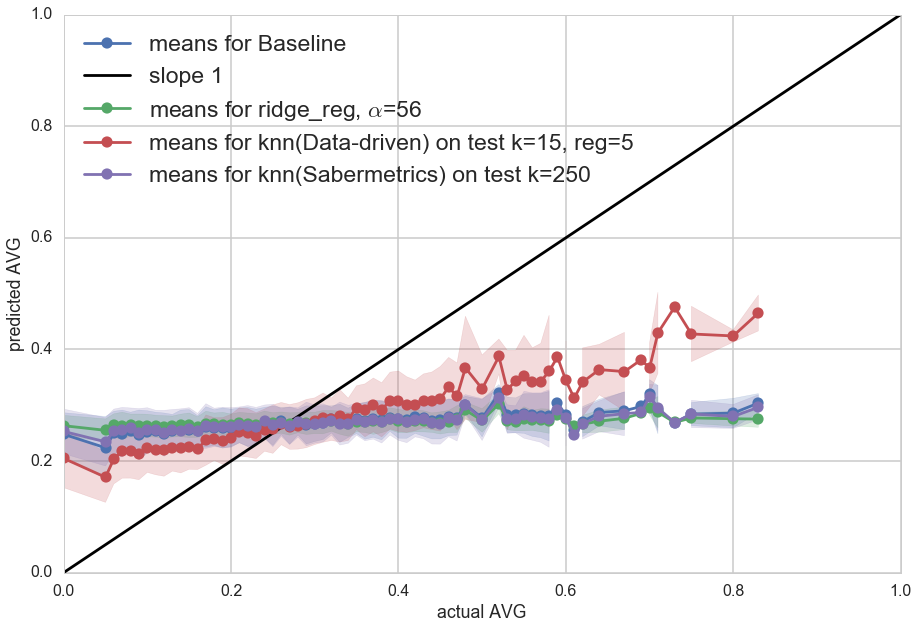

In [115]:
fig, ax = plt.subplots(figsize=(15,10))
compare_results(testdf.AVG, predictions['baseline'], model='Baseline', axis=ax)
compare_results(testdf.AVG,predictions['ridge_reg'], model=r"ridge_reg, $\alpha$="+'%d'%clf.get_params()['alpha'], onsame=ax);
compare_results(testdf.AVG,predictions['knn_data'], model=("knn(Data-driven) on test k=" + str(bestk_data) + ", reg=" + str(bestreg_data)), onsame=ax)
compare_results(testdf.AVG,predictions['knn_saber'], model=("knn(Sabermetrics) on test k=" + str(bestk_saber)), onsame=ax)

While we do not have too much accuracy with any of our models to predict batting averages and have a pretty high RMSE for all models, we do see that there is a slight but clear improvement for our data-driven kNN model using pitcher similarities. While not the most accurate model in the world, it could provide an advantage that baseball managers can use to predict which of two batters might be more successful against a given pitcher, even if the point estimates of the batting average are not totally accurate. It could also give a statistical advantage over random guessing using batting averages (our baseline model) for placing bets on baseball, which is significant considering the emerging market of fantasy baseball.

Overall, our lack of success in creating an extremely predictive model may have been because we were trying to fit "noise." In other words, there is a lot of randomness and luck that comes into play in baseball. A one-millimeter difference on the location a batter's bat strikes the ball can be the difference between a pop-fly out and a home run, meaning it could make the difference between winning or losing a game or championship. With so much randomness at play during every single pitch, it is not that surprising that we would have such trouble fitting a model to predict batting average. Even the most sophisticated and elaborate statistical models possible would have lots of trouble predicting those random aspects of baseball that affect an at-bat. 

Potential continuations of our models include examining more physical characteristics of batters and pitchers, as well as their specific skills.  For example, some pitchers use a technique known as a "submarine" whereas other pitchers use the traditional overhand movement.  We could also develop a more complicated model that takes into account batter similarity, and using similar batters' success against a given pitcher to help predict the batter's success. Adding variables that take into account more of the intricacies of each player might result in a more predictive model.